### This is my solution to the assignment by flixstock.

In [92]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [93]:
from fastai import *
from fastai.vision import *
from fastai.tabular import *
import pandas as pd
import gc

In [94]:
!cp -r ../input/data .

In [95]:
!ls 

__notebook_source__.ipynb  data


In [96]:
! apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


In [97]:
!tree data

data
├── attributes.csv
├── images
│   ├── 00796be2-00f2-4dbb-a56f-8de3d476fb261528438207019-ESPRIT-Men-Tshirts-481528438206880-5.jpg
│   ├── 00a990bd-09dd-4a86-b735-306874c06f9e1525935354085-Dream-of-Glory-Inc-Men-Green-Solid-Polo-Collar-T-shirt-5341525935353910-4.jpg
│   ├── 0117ff63-32ea-41b9-91ea-e0a1dc8013cb1527919734744-NA-831527919734624-3.jpg
│   ├── 014b4a11-4f18-4d0c-bb0f-5f51923084491535792174250-United-Colors-of-Benetton-Men-Grey-Printed-Round-Neck-T-shir-3.jpg
│   ├── 01964354-8603-4480-b77d-e4878da771301528525592577-Killer-Men-Blue-Colourblocked-Round-Neck-T-shirt-74515285255-2.jpg
│   ├── 01a05ca1-4745-4ee0-966b-fa5d8c34ae9c1527940268826-Campus-Sutra-Printed-Men-V-neck-Blue-T-Shirt-141152794026782-5.jpg
│   ├── 01d2bea9-f7d9-4a18-ae76-9ea1c7eecfc51526881788607-Duke-Men-Off-White-Printed-Polo-Collar-T-shirt-2061526881786955-1.jpg
│   ├── 01dc13d2-75e9-457f-bd37-19a33a1896651528520263133-Roadster-Men-Red-Striped-Polo-Collar-T-shirt-762152852026175-2.jpg
│   ├── 01e5c072-b3

In [98]:
data_path = Path("data")

In [99]:
data_path

PosixPath('data')

In [100]:
data_path.ls()

[PosixPath('data/attributes.csv'),
 PosixPath('data/models'),
 PosixPath('data/images')]

In [101]:
df = pd.read_csv(data_path/"attributes.csv")

In [102]:
df.head()

,filename,neck,sleeve_length,pattern
0,cdc8cd2a-0938-4970-a3b5-f5ed9595222c1527925869...,6.0,NaN,4.0
1,11469770662809-Metersbonwe-Navy-T-shirt-485146...,5.0,3.0,9.0
2,11479107741104-Tommy-Hilfiger-Men-Navy-Blue-St...,6.0,1.0,9.0
3,f7ad67ab-eeb1-4449-8f63-7b580d2797e71532342804...,NaN,0.0,9.0
4,11516770810185-Splash-Men-Tshirts-767151677081...,6.0,3.0,9.0


In [103]:
orig_new_ref = {}

for lbl in df.columns[1:]:
    ## Step 2.a, 2.b
    df[f"{lbl}_NaN"] = (df[lbl].isnull().astype(float))     
    ## Step 2.c 
    mean = df[lbl].mean()
    df[lbl].fillna(value=round(mean), inplace=True)
    unique_vals = sorted(df[lbl].dropna().unique())
    orig_new_ref[lbl] = {}
    orig_new_ref[lbl]["orig"] = unique_vals
    orig_new_ref[lbl]["new"] = [f"{lbl}{int(x)}" for x in unique_vals]
    df[lbl].replace(orig_new_ref[lbl]["orig"], orig_new_ref[lbl]["new"], inplace=True)


df["attr"] = ""
for i in df.columns[1:4]:
    ## Step 2.d
    if df["attr"].all() == "":
        df["attr"] = df[i]
    else:
        df["attr"] = df["attr"] + " : " + df[i]

In [104]:
df.head()

,filename,neck,sleeve_length,pattern,neck_NaN,sleeve_length_NaN,pattern_NaN,attr
0,cdc8cd2a-0938-4970-a3b5-f5ed9595222c1527925869...,neck6,sleeve_length3,pattern4,0.0,1.0,0.0,neck6 : sleeve_length3 : pattern4
1,11469770662809-Metersbonwe-Navy-T-shirt-485146...,neck5,sleeve_length3,pattern9,0.0,0.0,0.0,neck5 : sleeve_length3 : pattern9
2,11479107741104-Tommy-Hilfiger-Men-Navy-Blue-St...,neck6,sleeve_length1,pattern9,0.0,0.0,0.0,neck6 : sleeve_length1 : pattern9
3,f7ad67ab-eeb1-4449-8f63-7b580d2797e71532342804...,neck4,sleeve_length0,pattern9,1.0,0.0,0.0,neck4 : sleeve_length0 : pattern9
4,11516770810185-Splash-Men-Tshirts-767151677081...,neck6,sleeve_length3,pattern9,0.0,0.0,0.0,neck6 : sleeve_length3 : pattern9


## Pre processing

In [105]:
def remove_ghost_data(df:pd.DataFrame=None, data_path:pathlib.Path=None, inplace:bool=True, col=None):
    for x in df[col]:
        if not (data_path/x).exists():
            print(x)
            df.drop(df[df[col] == x].index, inplace=inplace)
    if inplace:
        return None
    else:
        return df

In [106]:
remove_ghost_data(df=df, data_path=data_path/"images", inplace=True, col="filename")

11495010560702-The-Indian-Garage-Co-Men-Tshirts-7851495010560569-2.jpg


In [107]:
df.shape

(2237, 8)

# Creating Dataset

In [108]:
## Doing transforms. Using default here as the images are have top/bottom distinction
## Default contains left-right flip and rotaion of 10 degrees.
tfms = get_transforms()

In [109]:
## Creating the train/valid dataset
src = (ImageList.from_df(df=df, path=data_path, cols=["filename"], folder="images")
       .split_by_rand_pct(0.2)
       .label_from_df(cols = "attr", label_delim=":"))

In [110]:
src

LabelLists;

Train: LabelList (1790 items)
x: ImageList
Image (3, 300, 225),Image (3, 300, 225),Image (3, 300, 225),Image (3, 300, 225),Image (3, 300, 225)
y: MultiCategoryList
neck6 ; sleeve_length3 ; pattern4,neck5 ; sleeve_length3 ; pattern9,neck6 ; sleeve_length1 ; pattern9,neck4 ; sleeve_length0 ; pattern9,neck1 ; sleeve_length3 ; pattern8
Path: data;

Valid: LabelList (447 items)
x: ImageList
Image (3, 300, 225),Image (3, 300, 225),Image (3, 300, 225),Image (3, 300, 225),Image (3, 300, 225)
y: MultiCategoryList
neck4 ; sleeve_length3 ; pattern9,neck2 ; sleeve_length3 ; pattern9,neck6 ; sleeve_length3 ; pattern9,neck6 ; sleeve_length1 ; pattern9,neck5 ; sleeve_length3 ; pattern9
Path: data;

Test: None

In [111]:
## Applying the transforms on the datasets
## Here I'm resizing the images and using a batchsize of 16
## Also I'm normalizing the images with imagenet_stats as I will be using a pretrained resnet arch (which is trained on imagenet data)
## So it becomes necessary to normalize our data ith the same stats to use the pretrained weights
data = (src.transform(tfms, size=128)
       .databunch(bs=16)
       .normalize(imagenet_stats))

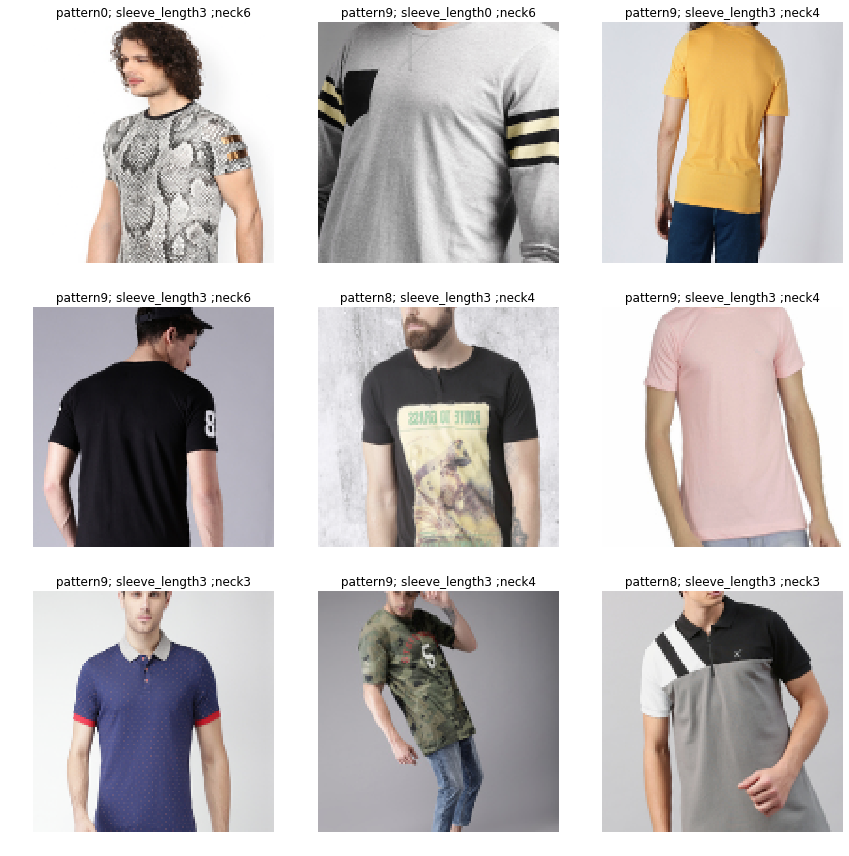

In [112]:
## Displying the images and labels in the dataset
data.show_batch(rows=3)

In [113]:
## This shows the total number of unique classes based on out labels from the dataframe used in creating the dataset
data.c

21

In [114]:
## This shows all the unique labels that will be used to create multi-hot-encoded label vector for each input image
## on which the loss will be calculated.
## The loss function that is being used in BCEWithLogitsLoss which is well suited for multilabe classification (its default as well)
data.classes

[' pattern0',
 ' pattern1',
 ' pattern2',
 ' pattern3',
 ' pattern4',
 ' pattern5',
 ' pattern6',
 ' pattern7',
 ' pattern8',
 ' pattern9',
 ' sleeve_length0 ',
 ' sleeve_length1 ',
 ' sleeve_length2 ',
 ' sleeve_length3 ',
 'neck0 ',
 'neck1 ',
 'neck2 ',
 'neck3 ',
 'neck4 ',
 'neck5 ',
 'neck6 ']

In [115]:
## garbage collection to free memory
gc.collect()

57459

# Model Design and Training

In [116]:
## Downloading the imagenet pretrained arch and its weights
## I am using resnet50 architecture due to limitaions of GPU 
arch = models.resnet50

In [117]:
## This learner binds the dataset and the model for training
## This also recordes all the events during training/validation
learner = cnn_learner(data, arch)

In [118]:
## This displays the complete architecture of the model and the training hyperparams that will be used.
## It also displays the optimization strategy and loss criterion. Defaulst optimization is Adam with momentum
learner

Learner(data=ImageDataBunch;

Train: LabelList (1790 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
neck6 ; sleeve_length3 ; pattern4,neck5 ; sleeve_length3 ; pattern9,neck6 ; sleeve_length1 ; pattern9,neck4 ; sleeve_length0 ; pattern9,neck1 ; sleeve_length3 ; pattern8
Path: data;

Valid: LabelList (447 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
neck4 ; sleeve_length3 ; pattern9,neck2 ; sleeve_length3 ; pattern9,neck6 ; sleeve_length3 ; pattern9,neck6 ; sleeve_length1 ; pattern9,neck5 ; sleeve_length3 ; pattern9
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel

In [119]:
## Now we begin our trainign process.
## Step-1: find the appropriate learning rate to be used to traing the model (both in unfrozen and frozen layers)
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


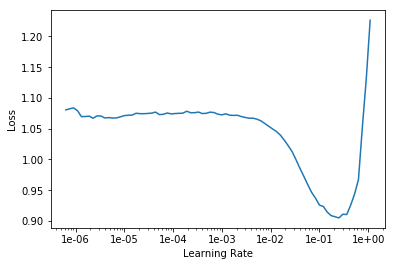

In [120]:
## This recorder plots the range of learning rates we can choose from.
## A good strategy to choose the learning rates range is to pick a range just before the loss increases monotonically
## till a point where loss drops monotonically the fastest
learner.recorder.plot()

In [121]:
## Based on above plot, a good learning rate range would be (1e-3, 1e-1)
## The purpose of slice in below function is to distribute the learning rates equally to all the UNFROZEN layers 
## (the last layer only for now as we're using a pretrained model and it would be unwise to throw away the learned weight before the untrained layer learns anything)
## cyc_len is the total number of ONE_CYCLE epochs we want the network to train, inspired from the research by Leslie Smith's CYCLICAL_TRAINING (fit_one_cycle())
learner.fit_one_cycle(cyc_len=5, max_lr=slice(1e-3, 1e-1))

epoch,train_loss,valid_loss,time
0,0.439657,0.323950,00:12
1,0.423538,0.437198,00:12
2,0.353886,0.506073,00:12
3,0.291041,0.790358,00:12
4,0.259410,1.148699,00:13


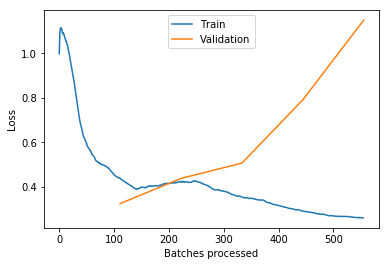

In [122]:
## plot the loss functions for trainign and validation sets
learner.recorder.plot_losses()

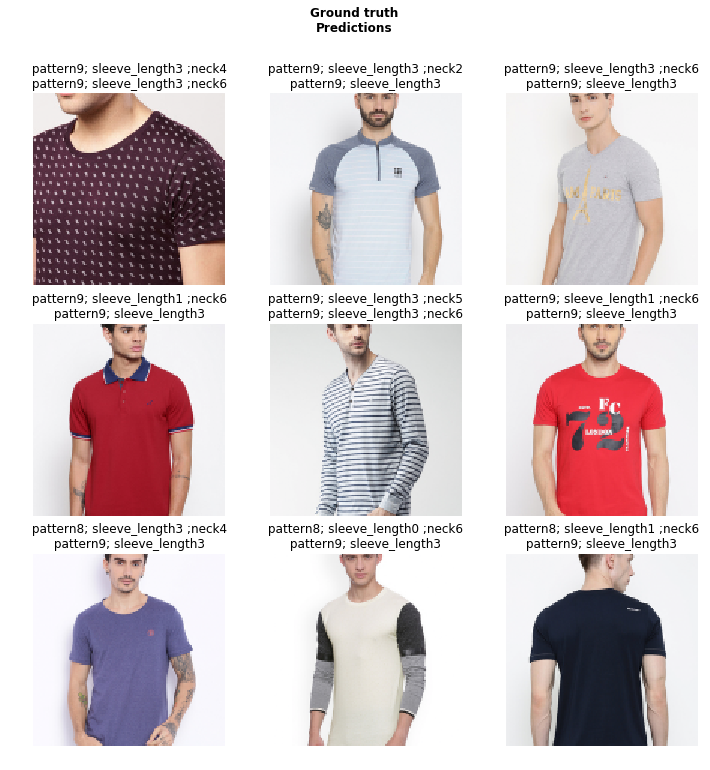

In [123]:
## See the results from the validation set
learner.show_results(rows=3)

In [124]:
## Save the model trained so that if the model performance worses after we train more; we can always reload the saved weight
learner.save("level-1_128")


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


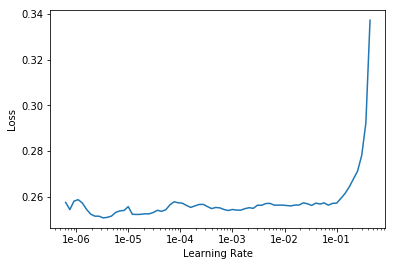

In [131]:
## Step-2: NOW we will unfreeze all the layers of the network and train end-to-end on our dataset.
## So, we will find the learning rates again using lr_find()
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [66]:
## Here we see that the curvature of learning rate v/s loss has changed.
## This is due to the fact that now to find the loss; lr_find() runs tests on the model 

In [136]:
## Lets first try with the same learning rates that we used
learner.fit_one_cycle(5, slice(1e-4, 1e-1))

epoch,train_loss,valid_loss,time
0,0.248592,9.755399,00:13
1,0.260500,549.532959,00:13
2,0.253518,9.784546,00:13
3,0.242893,4.925757,00:13
4,0.238791,8.077461,00:13


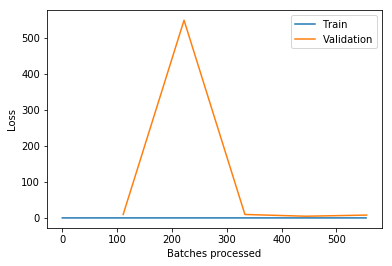

In [137]:
learner.recorder.plot_losses()

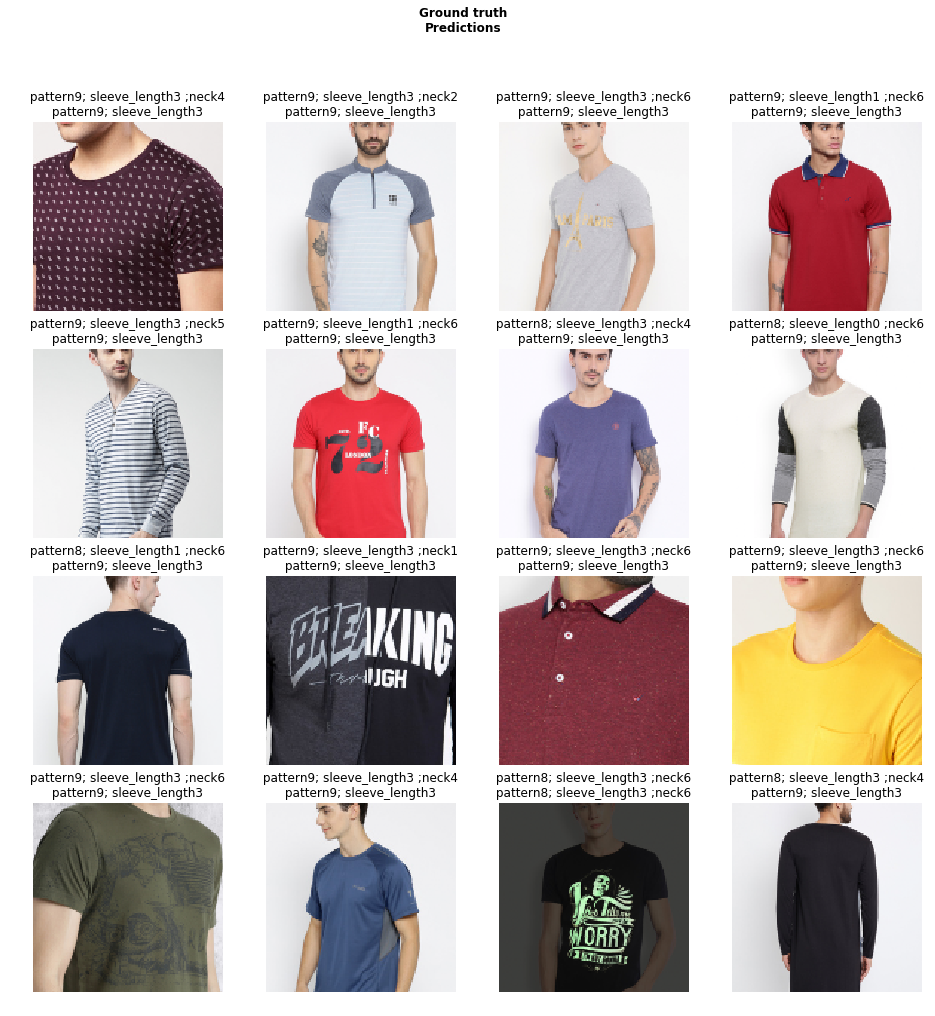

In [138]:
learner.show_results()

In [139]:
## Saving this freshly trained model end-to-end
learner.save("stage-2_128")

In [140]:
gc.collect()

30212

### Now we are going to do a smart trick to train our model evenm better. During earlier training (stage-1, satge-2) we had used a resized version of our input images (128, 128) and we got decent performance. Now the strategy is to use the a better resolution (256, 256) of exactly the same traina nd validation splits and train our model end-to-end

In [141]:
## using ths same source of data as before but with newer transforms and batch size
data = (src.transform(tfms, size=256)
       .databunch(bs=8)
       .normalize(imagenet_stats))

In [142]:
## Unfreezing all the layers of the resnet50 model to be trained on new resolution version of the exactly the same dataset
learner.unfreeze()

In [143]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


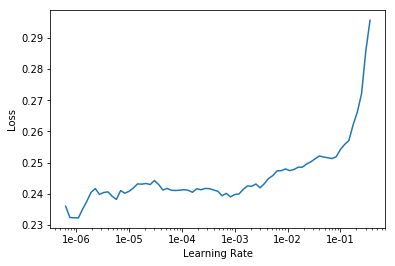

In [144]:
learner.recorder.plot()

In [145]:
learner.fit_one_cycle(5, slice(1e-5, 5e-3))

epoch,train_loss,valid_loss,time
0,0.239068,12.195582,00:24
1,0.242252,12.632845,00:24
2,0.233882,2.757128,00:24
3,0.230020,1.388518,00:24
4,0.227361,5.918352,00:24


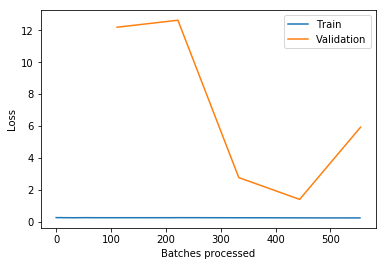

In [146]:
learner.recorder.plot_losses()

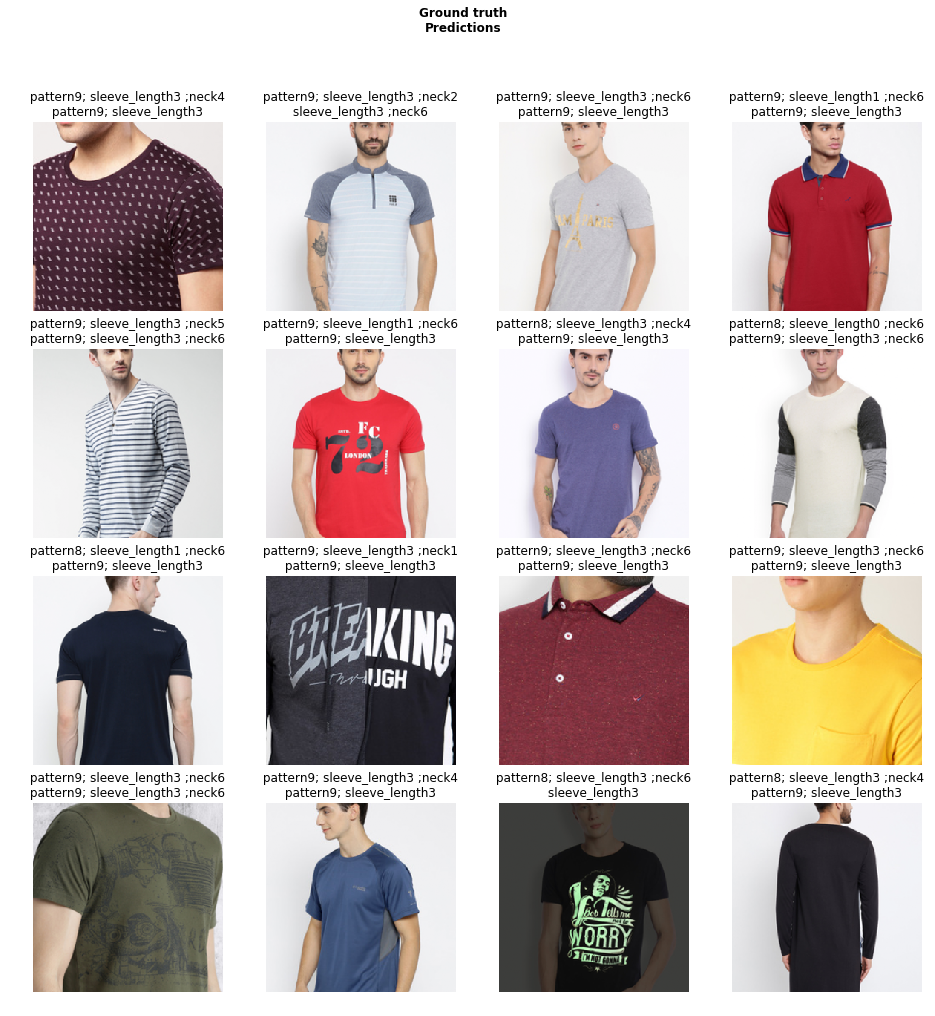

In [147]:
learner.show_results()

In [148]:
gc.collect()

39076

In [150]:
p = learner.get_preds()
print(p[0][0])
p[1][0]

tensor([2.6683e-03, 4.5457e-04, 3.5719e-03, 6.3993e-03, 6.8035e-03, 5.6238e-03,
        2.7894e-02, 7.2486e-03, 1.7098e-01, 7.6842e-01, 1.5101e-02, 1.4115e-01,
        5.3514e-02, 7.6466e-01, 3.4804e-02, 1.4794e-02, 5.6562e-02, 4.5294e-02,
        3.2609e-01, 7.7466e-02, 4.3736e-01])


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 0., 0.])

## Thankyou!!